In [1]:
import numpy as np
import time
import os
import cv2

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [2]:
import sys

print(sys.executable)

/nethome/jbang36/anaconda3/envs/eva_35/bin/python


In [3]:
# Set the dataset paths
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

'/home/jbang36/eva/data/ua_detrac/small-data'

In [29]:
def load_images_nn(image_dir, downsize_rate = 1):
    """
    Loading images in a non normalized form
    :param image_dir:
    :param downsize_rate:
    :param grayscale:
    :return:
    """
    image_height = 540
    image_width = 960
    file_names = []
    print(image_dir)
    #tmp = '/nethome/jbang36/eva/data/ua_detrac'
    mvi_dir = os.listdir(image_dir)
    mvi_dir.sort()
    
    for mvi in mvi_dir:
        if mvi == "README.md" or mvi == "download.sh" or mvi == "unzip.sh":
            continue
        image_files = os.listdir(os.path.join(image_dir, mvi))
        image_files.sort()
        for image_file in image_files:
            file_names.append(os.path.join(image_dir, mvi, image_file))
        
    print("Length of file_names", len(file_names))
    print(file_names[0])

    
    img_table = np.ndarray(shape=(len(file_names), int(image_height / downsize_rate), int(image_width / downsize_rate)))
    
    for i in range(len(file_names)):
        file_name = file_names[i]
        img = cv2.imread(file_name,0)
        img = cv2.resize(img, (image_width // downsize_rate, image_height // downsize_rate))
        img_table[i] = img

    return img_table

image_table = load_images_nn(data_dir, downsize_rate = 1)

/home/jbang36/eva/data/ua_detrac/small-data
Length of file_names 10421
/home/jbang36/eva/data/ua_detrac/small-data/MVI_20011/img00001.jpg


In [30]:
# split the training and test data
image_table = image_table[:,:,:,np.newaxis]

In [6]:
image_table.shape

(10421, 540, 960, 1)

(540, 960, 1)
(540, 960)
(540, 960)


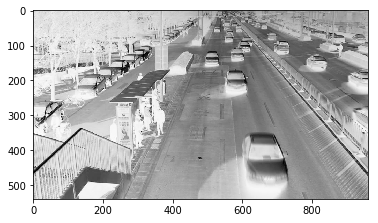

In [31]:
# Show a sample image from dataset
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

example = train_x[image_index]
width, height, channels = example.shape
example = np.squeeze(example)
print(np.squeeze(example).shape)
print(example.shape)

plt.imshow(example, cmap='Greys')

In [32]:
## Load the annotations
## TODO: Modify so that we only have car_labels

import xml.etree.ElementTree as ET


anno_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-annotations')

car_labels = []

anno_files = os.listdir(anno_dir)
anno_files.sort()

for anno_file in anno_files:
    file_path = os.path.join(anno_dir, anno_file)
    if ".swp" in file_path:
        continue
    tree = ET.parse(file_path)
    tree_root = tree.getroot()
    start_frame_num = 1
    start_frame = True
    for frame in tree_root.iter('frame'):
        curr_frame_num = int(frame.attrib['num'])
        if start_frame and curr_frame_num != start_frame_num:
            car_labels.append( [None] * (curr_frame_num - start_frame_num) )
        car_per_frame = []
        bboxes = []
        for box in frame.iter('box'):
            left = int(eval(box.attrib['left']))
            top = int(eval(box.attrib['top']))
            right = left + int(eval(box.attrib['width']))
            bottom = top + int(eval(box.attrib['height']))
            bboxes.append([left, top, right, bottom])
            # curr_frame_num -1 comes from the fact that indexes start from 0 whereas the start_frame_num = 1
            

        for att in frame.iter('attribute'):
            if (att.attrib['vehicle_type']):
                car_per_frame.append(att.attrib['vehicle_type'])
            
        if len(car_per_frame) == 0:
            car_labels.append(None)
        else:
            car_labels.append(car_per_frame)
        start_frame = False


In [33]:
def _generate_binary_labels(Y):
    """
    Example label dict is going to be {"car": [0,0,0,1,0,0,0.....],"others": [0,1,0,0,0...}
    :param X:
    :return:
    """

    labels = {"vehicle_type": ["car", "van", "bus", "others"],
                  "color": ["red", "white", "black", "silver"],
                  "speed": ["s>40", "s>50", "s>60", "s<65", "s<70"],
                  "intersection": ["pt335", "pt211", "pt342", "pt208"]}

    Y_names = ["t=car", "t=van", "t=bus", "t=others"]
    Y_table = np.zeros(shape=(len(Y), len(Y_names)))
    
    print(Y_table.shape)

    for idx, frame in enumerate(Y):
        if "car" in frame:
            Y_table[idx][0] = 1
        if "van" in frame:
            Y_table[idx][1] = 1
        if "bus" in frame:
            Y_table[idx][2] = 1
        if "others" in frame:
            Y_table[idx][3] = 1

    return [Y_names, Y_table]
        
Y_names, Y_table = _generate_binary_labels(car_labels)

(10421, 4)


In [22]:
Y_table

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.]])

In [34]:
# Reshape the input image
## Need to flatten and resize
def _reshape_image(X, sampling_rate = 8):
    """
    :param X: Input images
    :param sampling_rate: The reduction rate
    :return: the reshaped images
    """
    print(('inside reshape images, shape of image dataseries is ' + str(X.shape)))
    reduction_rate = sampling_rate
    #need to down shape them so that the kernels can train faster
    #image should be num_samples, height, width, channel
    downsampled_images = X[:,::reduction_rate,::reduction_rate,:]
    nsamples, nx, ny, nc = downsampled_images.shape
    reshaped_images = downsampled_images.reshape((nsamples, nx * ny * nc))
    return reshaped_images

reshaped_image_table = _reshape_image(image_table)
print(reshaped_image_table.shape)



inside reshape images, shape of image dataseries is (10421, 540, 960, 1)
(10421, 8160)


In [35]:
#Divide the test and training dataset
n_samples = reshaped_image_table.shape[0]
X_train = reshaped_image_table[:int(n_samples * 0.8)]
X_test = reshaped_image_table[int(n_samples * 0.8):]

assert(reshaped_image_table.shape[0] == Y_table.shape[0])
Y_train = Y_table[:int(n_samples * 0.8)]
Y_test = Y_table[int(n_samples * 0.8):]

In [36]:
## Test PCA
def _pca(X):
    tic = time.time()
    pca = PCA()
    X_new = pca.fit_transform(X)
    print("Time it took to fit pca is: ", time.time() - tic, "seconds")
    return pca, X_new #we will return the models for the caller to save them

pca_model, pca_images = _pca(X_train)

Time it took to fit pca is:  74.17107582092285 seconds


In [37]:
# Test SVM
def _svm(X, Y_names, Y_table):
    """
    SVM Model
    :param X:Input Features
    :param Y_names: Output column names
    :param Y_table: Output columns values
    :return svm_models: The trained SVM models for each output feature
    """
    n_samples, n_columns = Y_table.shape
    svm_models = []
    assert(len(Y_names) == n_columns)
    for idx, Y in enumerate(Y_names):
        if len(np.unique(Y_table[:, idx])) == 1:
            print("All the labels are same for column", Y)
            svm_models.append(None)
            continue
        else:
            tic = time.time()
        
            svm = SVC(kernel = 'linear', probability = True)
            svm.fit(X, Y_table[:, idx])
        print("Time it took to fit svm is:", time.time() - tic, "seconds")
        svm_models.append(svm)

    return svm_models

svm_models = _svm(pca_images, Y_names, Y_train)

Time it took to fit svm is: 56.041266441345215 seconds
Time it took to fit svm is: 517.5268023014069 seconds
Time it took to fit svm is: 288.503910779953 seconds
Time it took to fit svm is: 125.91064691543579 seconds


In [39]:
print(Y_test)

[[1. 0. 1. 1.]
 [1. 0. 1. 1.]
 [1. 0. 1. 1.]
 ...
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]]


In [41]:
#what are the scores for test dataset?
for idx, svm_model in enumerate(svm_models):
    start_time = time.time()
    pca_test_images = pca_model.transform(X_test)
    score = svm_model.score(pca_test_images, Y_test[:,idx])
    print("Score for svm on test data is", score)
    print("Time it took for prediction is ", time.time() - start_time, "seconds")

Score for svm on test data is 1.0
Time it took for prediction is  2.4751598834991455 seconds
Score for svm on test data is 0.7016786570743405
Time it took for prediction is  20.30725598335266 seconds
Score for svm on test data is 0.7664268585131895
Time it took for prediction is  12.712414503097534 seconds
Score for svm on test data is 0.8613908872901679
Time it took for prediction is  5.346717834472656 seconds


In [44]:
  #random forest
def _rf(X, Y_names, Y_table):
    """
    Random Forest Model
    :param X:Input Features
    :param Y_names: Output column names
    :param Y_table: Output columns values
    :return rf_models: The trained RF models for each output feature
    """
    n_samples, n_columns = Y_table.shape
    rf_models = []
    assert(len(Y_names) == n_columns)
    for idx, Y in enumerate(Y_names):
        if len(np.unique(Y_table[:, idx])) == 1:
            print("All the labels are same for column", Y)
            rf_models.append(None)
            continue
        else:
            tic = time.time()
            rf = RandomForestClassifier(max_depth = 2, random_state = 0)
            rf.fit(X, Y_table[:, idx])
        print("Time it took to fit rf is:", time.time() - tic, "seconds")
        rf_models.append(rf)

    return rf_models
    
rf_models = _rf(pca_images, Y_names, Y_train)

/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Time it took to fit rf is: 1.3972387313842773 seconds


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Time it took to fit rf is: 1.1449933052062988 seconds


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Time it took to fit rf is: 1.1394360065460205 seconds


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Time it took to fit rf is: 1.1092593669891357 seconds


In [45]:
#what are the scores for test dataset?
for idx, rf_model in enumerate(rf_models):
    start_time = time.time()
    pca_test_images = pca_model.transform(X_test)
    score = rf_model.score(pca_test_images, Y_test[:,idx])
    print("Score for rf on test data is", score)
    print("Time it took for prediction is ", time.time() - start_time, "seconds")


Score for rf on test data is 0.9860911270983214
Time it took for prediction is  1.0239264965057373 seconds
Score for rf on test data is 0.6661870503597123
Time it took for prediction is  0.8166897296905518 seconds
Score for rf on test data is 0.6594724220623501
Time it took for prediction is  0.7593541145324707 seconds
Score for rf on test data is 0.9592326139088729
Time it took for prediction is  0.6922521591186523 seconds


In [49]:
from sklearn.neighbors import KernelDensity

def _kde(X, Y_names, Y_table):
    """
    KDE Model
    :param X:Input Features
    :param Y_names: Output column names
    :param Y_table: Output columns values
    :return kde_models: The trained KDE models for each output feature
    """
    n_samples, n_columns = Y_table.shape
    kde_models = []
    assert(len(Y_names) == n_columns)
    for idx, Y in enumerate(Y_names):
        if len(np.unique(Y_table[:, idx])) == 1:
            print("All the labels are same for column", Y)
            kde_models.append(None)
            continue
        else:
            tic = time.time()
            kde = KernelDensityWrapper(kernel='gaussian', bandwidth=0.2)
            # We will assume each label is one-shot encoding
            kde.fit(X, Y_table[:,idx])
            
            print("Time it took to fit kde is:", time.time() - tic, "seconds")
            kde_models.append(kde)
        
    return kde_models

class KernelDensityWrapper:
  #A wrapper class for sklearn kde to match the other models and wrap the logic behind using kde for classification

    def __init__(self, kernel='guassian', bandwidth=0.2):
        self.kernels = [] #assume everything is one shot
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X, y):
        assert(len(np.unique(y) == 2))
        
        kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth, algorithm='kd_tree')
        kde.fit(X[y == 0])
        self.kernels.append(kde)

        kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth, algorithm = 'kd_tree')
        kde.fit(X[y == 1])
        self.kernels.append(kde)


    def predict_proba(self, X):
        ##output the f value
        scores = []
        n_samples, _ = X.shape
        for kernel in self.kernels:
            log_dens = kernel.score_samples(X)
            probs = np.exp(log_dens)
            scores.append( probs )
        scores_np = np.array(scores)
        return scores_np[0] / scores_np[1]
    
    def score(self, X_test, Y_test):
        return np.exp(self.kernels[0].score(X_test, Y_test))
        
kde_models = _kde(pca_images, Y_names, Y_train)

Time it took to fit kde is: 4.2711522579193115 seconds
Time it took to fit kde is: 3.5531139373779297 seconds
Time it took to fit kde is: 3.4835126399993896 seconds
Time it took to fit kde is: 3.9587156772613525 seconds


In [58]:
print(round(0.2))
print(round(0.6))
print(np.round(np.array([0.1, 0.2, 0.3, 0.5, 0.6, 0.7])))

0
1
[0. 0. 0. 0. 1. 1.]


In [78]:
# Test all the functions defined above

n_samples, n_columns = Y_table.shape
assert(len(Y_names) == n_columns)
pca_test_images = pca_model.transform(X_test)
t1 = time.time()

X_train_plus = pca_images[Y_train[:,3] == 1]
print("Length of X_train_plus", len(X_train_plus))

kde_plus = KernelDensity(kernel='gaussian', algorithm='kd_tree', bandwidth = 3)
start_time = time.time()
kde_plus.fit(X_train_plus)
print("Kde plus training time: ", time.time() - start_time)

X_train_minus = pca_images[Y_train[:,3] == 0]
print("Length of X_train_minus", len(X_train_minus))
kde_minus = KernelDensity(kernel='gaussian', algorithm='kd_tree', bandwidth = 3)
start_time = time.time()
kde_minus.fit(X_train_minus)
print("Kde minus training time: ", time.time() - start_time, "seconds")


Length of X_train_plus 433
Kde plus training time:  0.03692173957824707
Length of X_train_minus 7903
Kde minus training time:  3.066826581954956 seconds


In [79]:
t1 = time.time()
pca_test_images = pca_model.transform(X_test)
print("PCA transform time", time.time() - t1)

plus_scores = kde_plus.score_samples(pca_test_images)
minus_scores = kde_minus.score_samples(pca_test_images)

print("Plus_scores")
print(plus_scores[:10])
print("Minus_scores")
print(minus_scores[:10])

final_scores = plus_scores > minus_scores
print(final_scores[:10])
print("----------------")
print(Y_test[:10,idx])

equal_array = final_scores == Y_test[:, idx]
print(equal_array)
final_score = len(equal_array[equal_array == 1]) / len(scores)

print("score is: ", final_score)

PCA transform time 0.816455602645874
Plus_scores
[ -88928.50766643 -127705.78544421 -186461.1743331  -252107.6743331
 -330800.22988866 -448795.11877754 -569841.34099976 -599800.1743331
 -690191.11877755 -840852.1743331 ]
Minus_scores
[-1520727.57859308 -1513612.07859309 -1503543.35637086 -1500690.96748197
 -1489613.18970419 -1466002.85637085 -1461305.30081531 -1460383.80081531
 -1485787.63414864 -1513569.46748198]
[ True  True  True  True  True  True  True  True  True  True]
----------------
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ True  True  True ... False False False]
score is:  0.6326139088729017


In [72]:
print(len(final_scores[final_scores == False]))
print(len(final_scores[final_scores == True]))

664
1421


In [66]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV


n_samples, n_columns = Y_table.shape
assert(len(Y_names) == n_columns)
pca_test_images = pca_model.transform(X_test)
for idx, Y in enumerate(Y_names):
    t1 = time.time()
    #params = {'bandwidth': np.logspace(-1, 1, 20)}
    #grid = GridSearchCV(KernelDensity(kernel='gaussian', algorithm='kd_tree'), params, cv=5)
    
    X_train_plus = pca_images[Y_train[:,idx] == 1]
    #grid.fit(X_train_plus)
    #kde_plus = grid.best_estimator_
    kde_plus = KernelDensity(kernel='gaussian', algorithm='kd_tree', bandwidth = 3)
    start_time = time.time()
    kde_plus.fit(X_train_plus)
    print("Kde plus training time: ", time.time() - start_time)
    # We will assume each label is one-shot encoding
    
    #grid = GridSearchCV(KernelDensity(kernel='gaussian', algorithm='kd_tree'), params, cv=5)
    X_train_minus = pca_images[Y_train[:,idx] == 0]
    #grid.fit(X_train_minus)
    #kde_minus = grid.best_estimator_
    kde_minus = KernelDensity(kernel='gaussian', algorithm='kd_tree', bandwidth = 3)
    start_time = time.time()
    kde_minus.fit(X_train_minus)
    print("Kde minus training time: ", time.time() - start_time, "seconds")
    
    
    
    plus_scores = np.exp(kde_plus.score_samples(X_test))
    minus_scores = np.exp(kde_minus.score_samples(X_test))
    
    final_scores = plus_scores > minus_scores
    print(final_scores[:10])
    print("----------------")
    print(Y_test[:10,idx])
    
    equal_array = final_scores == Y_test[:, idx]
    final_score = len(equal_array[equal_array == 1]) / len(scores)
    
    print("score is: ", final_score)
    print("whole cycle took:", time.time() - t1, "seconds")
    
    
    
    
    



    


Kde plus training time:  3.2611610889434814
Kde minus training time:  0.0045680999755859375
[False False False False False False False False False False]
----------------
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score is:  0.0
Kde plus training time:  1.7731928825378418
Kde minus training time:  0.7689144611358643
[False False False False False False False False False False]
----------------
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
score is:  0.3333333333333333
Kde plus training time:  1.8237066268920898
Kde minus training time:  0.6628763675689697
[False False False False False False False False False False]
----------------
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score is:  0.30551558752997604
Kde plus training time:  0.03340482711791992
Kde minus training time:  3.0537221431732178
[False False False False False False False False False False]
----------------
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score is:  0.9592326139088729


In [51]:
#what are the scores for test dataset?
for idx, kde_model in enumerate(kde_models):
    start_time = time.time()
    pca_test_images = pca_model.transform(X_test)
    probas = kde_model.predict_proba(pca_test_images)
    print(probas)
    #score = kde_model.score(pca_test_images, Y_test[:,idx])
    #print("Score for kde on test data is", score)
    #print("Time it took for prediction is ", time.time() - start_time, "seconds")


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


[nan nan nan ... nan nan nan]


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


[nan nan nan ... nan nan nan]


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


/nethome/jbang36/anaconda3/envs/eva_35/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [105]:
pca_test_images = pca_model.transform(X_test)

f_x1 = svm_models[0].predict_proba(pca_test_images)[:,1] #we extract the X_test == 1 only
f_x0 = svm_models[0].predict_proba(pca_test_images)[:,0]

print(Y_test[:10, 0])
print(f_x1[:10])
print(f_x0[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.07277713e-12 1.09357476e-13 5.64065757e-14 3.00000090e-14
 3.00000090e-14 3.00000090e-14 3.00000090e-14 3.00000090e-14
 3.00000090e-14 3.00000090e-14]


In [109]:
# Postprocessing Method
"""
th[a] = max th s.t. (f(x) > th / l(x) = +1) >= a

r[a] = 1 - |f(x) > th[a]| / |D|

Now let's assume a target confidence is given.... for example 90
"""

def post_process(X, y, model, target_a):
    """
    we aim to output th[a] and r[a]
    """
    th_ = 0
    step_size = 0.01
    f_x = model.predict_proba(X)[:,1] #we extract the X_test == 1 only
    left_side = len(f_x[f_x > th_]) / len(y[y == 1])
    
    assert(len(f_x) == len(y))
    assert(len(y) >= len(y[y==1]))

    while left_side >= target_a:
        th_ += step_size
        left_side = len(f_x[f_x > th_]) / len(y[y == 1])
        
        
    th_ -= step_size
    r_ = 1 - len(f_x[f_x > th_]) / len(y)
    
    return th_, r_
            


In [110]:
# For any model, let's test what the th_, r_ values are
pca_test_images = pca_model.transform(X_test)

for idx, svm_model in enumerate(svm_models):
    th_90, r_90 = post_process(pca_test_images, Y_test[:, idx], svm_model, 0.90)
    th_95, r_95 = post_process(pca_test_images, Y_test[:, idx], svm_model, 0.95)
    
    print("[90], th value:", th_90, "r value:", r_90)
    print("[95], th value:", th_95, "r value:", r_95)
    print("-----------------------------------------")

    

proba array [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
proba array [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[90], th value: 0.9900000000000007 r value: 0.0004796163069544779
[95], th value: 0.9900000000000007 r value: 0.0004796163069544779
-----------------------------------------
proba array [0.00052066 0.00312723 0.04429172 0.00386697 0.00731833 0.00780757
 0.00171664 0.04924667 0.05924131 0.14695412]
proba array [0.00052066 0.00312723 0.04429172 0.00386697 0.00731833 0.00780757
 0.00171664 0.04924667 0.05924131 0.14695412]
[90], th value: 0.9900000000000007 r value: 0.1390887290167866
[95], th value: 0.9900000000000007 r value: 0.1390887290167866
-----------------------------------------
proba array [0.99999991 0.99999992 0.99999999 1.         1.         1.
 1.         0.99999966 0.99999452 0.99999907]
proba array [0.99999991 0.99999992 0.99999999 1.         1.         1.
 1.         0.99999966 0.99999452 0.99999907]
[90], th value: 0.8200000000000005 r value: 0.37410071942446044
[95], th value: 0.6800

In [111]:
for idx, svm_model in enumerate(rf_models):
    th_90, r_90 = post_process(pca_test_images, Y_test[:, idx], svm_model, 0.90)
    th_95, r_95 = post_process(pca_test_images, Y_test[:, idx], svm_model, 0.95)
    
    print("[90], th value:", th_90, "r value:", r_90)
    print("[95], th value:", th_95, "r value:", r_95)
    print("-----------------------------------------")

proba array [0.8036528  0.82159685 0.72766937 0.71618189 0.78978475 0.71168388
 0.70221333 0.82509913 0.5793166  0.6489549 ]
proba array [0.8036528  0.82159685 0.72766937 0.71618189 0.78978475 0.71168388
 0.70221333 0.82509913 0.5793166  0.6489549 ]
[90], th value: 0.5900000000000003 r value: 0.0988009592326139
[95], th value: 0.5500000000000003 r value: 0.041247002398081545
-----------------------------------------
proba array [0.56071394 0.57335698 0.56071394 0.58852348 0.6238372  0.6238372
 0.6238372  0.6238372  0.64803447 0.611212  ]
proba array [0.56071394 0.57335698 0.56071394 0.58852348 0.6238372  0.6238372
 0.6238372  0.6238372  0.64803447 0.611212  ]
[90], th value: 0.6500000000000004 r value: 0.3213429256594724
[95], th value: 0.6500000000000004 r value: 0.3213429256594724
-----------------------------------------
proba array [0.65990919 0.72511007 0.64212726 0.70605318 0.67438057 0.59139776
 0.61500138 0.73046335 0.69693508 0.64546421]
proba array [0.65990919 0.72511007 0.64

In [112]:
a = [1,2,3,4,5]
a.append([None] * 5)
print(a)

[1, 2, 3, 4, 5, [None, None, None, None, None]]


In [4]:
home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)




In [5]:
# Load data effeciently using the loader
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
train_image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
train_anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X_train, length_per_mvi = load.load_images(train_image_dir)
Y_train_dict = load.load_XML(train_anno_dir, X_train, length_per_mvi)

print("Starting assertions...")
assert (len(X_train.shape) == 4)  # n_samples, width, height, channels
assert (len(Y_train_dict) == 4)  # vehicle_type, color, intersection, speed
assert (X_train.shape[0] == len(Y_train_dict['color']))  # number of frames should be same
assert (X_train.shape[0] == len(Y_train_dict['vehicle_type']))
assert (X_train.shape[0] == len(Y_train_dict['intersection']))
assert (X_train.shape[0] == len(Y_train_dict['speed']))
print("Done with test!")
print("Total time to load small-data is", time.time() - start_time, "seconds")

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421
mvi length: 664
car_labels length: 664
mvi length: 1600
car_labels length: 1600
mvi length: 2037
car_labels length: 2037
mvi length: 2821
car_labels length: 2821
mvi length: 3621
car_labels length: 3621
mvi length: 4421
car_labels length: 4421
mvi length: 5327
car_labels length: 5327
mvi length: 6021
car_labels length: 6021
mvi length: 6821
car_labels length: 6821
mvi length: 7621
car_labels length: 7621
mvi length: 8421
car_labels length: 8421
mvi length: 9221
car_labels length: 9221
mvi length: 10421
car_labels length: 10421
Starting assertions...
Done with test!
Total time to load small-data is 50.6759192943573 seconds


In [ ]:

class PP:
    def __init__(self):

        self.model_library = {"pca_svm": self._svm,
                              #"dnn": self._dnn,
                              "pca_rf": self._rf} #KDE, SVM, NN - this should be a mapping of model name to model CONSTRUCTOR

        self.pre_data = {} #processed data through preprocessing methods
        self.validation_set = []
        self.trained_pre = {}
        self.trained_post = {}
        self.pre_stats = {}
        self.column_stats = {} #ex: {'pca_svm':[C value, Threshold Value, R value]}
        labels = {"vehicle_type": ["car", "van", "bus", "others"],
                      "color": ["red", "white", "black", "silver"],
                      "speed": ["s>40", "s>50", "s>60", "s<65", "s<70"],
                      "intersection": ["pt335", "pt211", "pt342", "pt208"]}


    def _generate_binary_labels(self, Y_dict, n_samples):
        """
        Example label dict is going to be {"car": [0,0,0,1,0,0,0.....],"others": [0,1,0,0,0...}
        :param Y_dict: dictionary for all the label categories
        :return: column names and a matrix that contains all the binary values
        """
        Y_names = ["t=car", "t=van", "t=bus", "t=others", "c=red", "c=white", "c=black", "c=silver",
                   "s>40", "s>50", "s>60", "s<65", "s<70", "i=pt335", "i=pt211", "i=pt342", "i=pt208",
                   "o=pt335", "o=pt211", "o=pt342", "o=pt208"]

        Y_table = np.zeros(shape=(n_samples,
                                  len(Y_names)))

        print(Y_table.shape)

        for column_name in Y_dict:
            for frameid, frame_content in enumerate(Y_dict[column_name]):
                if frame_content == None:
                    continue

                if column_name == "speed":
                    for speed_data in frame_content:
                        assert(type(speed_data) == float or type(speed_data) == int)
                        if speed_data > 40:
                            Y_table[frameid][Y_names.index("s>40")] = 1
                        if speed_data > 50:
                            Y_table[frameid][Y_names.index("s>50")] = 1
                        if speed_data > 60:
                            Y_table[frameid][Y_names.index("s>60")] = 1
                        if speed_data < 65:
                            Y_table[frameid][Y_names.index("s<65")] = 1
                        if speed_data < 70:
                            Y_table[frameid][Y_names.index("s<70")] = 1

                elif column_name == "intersection":
                    for intersection_data in frame_content:
                        assert(type(intersection_data) == str)
                        Y_table[frameid][Y_names.index("i="+intersection_data)] = 1
                        Y_table[frameid][Y_names.index("o="+intersection_data)] = 1

                elif column_name == "vehicle_type":
                    for vehicle_data in frame_content:
                        assert(type(vehicle_data) == str)
                        Y_table[frameid][Y_names.index("t="+vehicle_data)] = 1

                else:
                    assert(column_name == "color")
                    for color_data in frame_content:
                        assert(type(color_data) == str)
                        Y_table[frameid][Y_names.index("c="+color_data)] = 1

        print(Y_names)
        print(Y_table[:10])
        return Y_names, Y_table

    def _reshape_image(self, X, sampling_rate = 8):
        """
        :param X: Input images
        :param sampling_rate: The reduction rate
        :return: the reshaped images
        """
        print("before:", X.shape)
        reduction_rate = sampling_rate
        #need to down shape them so that the kernels can train faster
        #image should be num_samples, height, width, channel
        downsampled_images = X[:,::reduction_rate,::reduction_rate,:]
        nsamples, nx, ny, nc = downsampled_images.shape
        reshaped_images = downsampled_images.reshape((nsamples, nx * ny * nc))
        print("After change, shape of image is", reshaped_images.shape)
        return reshaped_images


    def _split_train_val(self, X, Y_table):
        """
        Split the given training data to training and valiation set
        :param X: Train images
        :param Y_table: Train labels
        :return: Train/Val images, Train/Val labels
        """
        n_samples = len(X)
        X_train = X[:int(n_samples * 0.8)]
        X_test = X[int(n_samples * 0.8):]
        Y_train = Y_table[:int(n_samples * 0.8)]
        Y_test = Y_table[int(n_samples * 0.8):]

        assert(len(X_train) == len(Y_train))
        assert(len(X_test) == len(Y_test))
        assert(len(X_train) + len(X_test) == len(X))

        print("X_train shape", X_train.shape)
        print("X_val shape", X_test.shape)
        print("Y_train shape", Y_train.shape)
        print("Y_vale shaep", Y_test.shape)
        return X_train, X_test, Y_train, Y_test


    #TODO
    def train(self, image_matrix, Y_dict):
        """
        :param image_matrix: Input images
        :param Y_dict: Labels for images
        """
        n_samples = len(image_matrix)
        print("Generating binary labels...")
        t1 = time.time()
        Y_names, Y_table = self._generate_binary_labels(Y_dict, n_samples)
        print("Done in", time.time() - t1, "seconds")
        
        print("reshaping images...")
        t1 = time.time()
        image_reshaped = self._reshape_image(image_matrix)
        print("Done in", time.time() - t1, "seconds")
        print("Splitting train / val...")
        t1 = time.time()
        X_train, X_val, Y_train, Y_val = self._split_train_val(image_reshaped, Y_table)
        print("Done in", time.time() - t1, "seconds")
        self.validation_set = [X_val, Y_names, Y_val]
        print("Starting preprocessing...")
        t1 = time.time()
        self._preprocess(X_train)
        print("Done in", time.time() - t1, "seconds")
        
        print("Starting processing...")
        t1 = time.time()
        self._process(X_train, Y_names, Y_train)
        print("Done in", time.time() - t1, "seconds")
        

    def _preprocess(self, X_train):
        """
        Preprocess the training data by applying PCA
        :param X_train: Training images
        """
        X_train_processed = self._pca(X_train)
        self.pre_data['pca'] = X_train_processed
        
        print("X_train shape: ", X_train.shape)
        print("X_train_pca shape: ", X_train_processed.shape)
        assert(X_train.shape[0] == X_train_processed.shape[0])
        assert(len(X_train.shape) == 2)
        assert(len(X_train_processed.shape) == 2)
        assert(X_train_processed.shape[1] < X_train.shape[1])
        
        

    def _process(self, X, Y_names, Y_table):
        for model_name, model_func in self.model_library.items():
            if 'pca' in model_name:
                model_func(self.pre_data['pca'], Y_names, Y_table)
            else:
                model_func(X, Y_names, Y_table)

    #TODO
    def get_reduction(self, target_a):
        """
        Post processing step - will get the target_a from the query optimizer / query parser
        :param target_a: target accuracy; a number between 0 and 1
        :return: relevant statistics such as c, r values for utilization calculation
        """
        X_val, Y_names, Y_val = self.validation_set
        assert(len(X_val) == len(Y_val))
        assert(len(Y_names) == len(Y_val[0]))

        X_val_processed = self.trained_pre['pca'].transform(X_val)
        for Y_col in self.trained_post:
            for model_name, model in self.column_stats[Y_col].items():
                if 'pca' in model_name:
                    probabilities = model.predict_proba(X_val_processed)[:, 1]
                else:
                    probabilities = model.predict_proba(X_val)[:, 1]

            index = Y_names.index(Y_col)
            th_, r_ = self._search_th_max(probabilities, Y_val[:, index], target_a)
            self.column_stats[Y_col][model_name].append(th_)
            self.column_stats[Y_col][model_name].append(r_)

        return self.column_stats

    def _search_th_max(self, f_x, y, target_a):
        th_ = 0
        step_size = 0.01
        left_side = len(f_x[f_x > th_]) / len(y[y == 1])

        while left_side >= target_a:
            th_ += step_size
            left_side = len(f_x[f_x > th_]) / len(y[y == 1])

        th_ -= step_size
        r_ = 1 - len(f_x[f_x > th_]) / len(y)

        return th_, r_


    def predict(self, X_test, column_name, model_name):
        """
        The prediction function
        :param X_test: Test Set
        :param column_name: The column to use
        :param model_name: The model to use
        :return y_final: The predicted labels.
        """
        X_test_reduced = self._reshape_image(X_test)
        model = self.column_library[column_name][model_name]

        if 'pca' in model_name:
            X_test_processed = self.trained_pre['pca'].transform(X_test_reduced)
            y_hat = model.predict_proba(X_test_processed)
        else:
            y_hat = model.predict_proba(X_test)

        th_ = self.column_stats[column_name][1]
        y_final = y_hat > th_
        return y_final


#############################################################################################
################################## MODELS ###################################################
#############################################################################################

  #random forest
    def _rf(self, X, Y_names, Y_table):
        """
        Random Forest Model
        :param X:Input Features
        :param Y_names: Output column names
        :param Y_table: Output columns values
        """
        for idx, Y_column in enumerate(Y_names):
            tic = time.time()
            rf = RandomForestClassifier(max_depth=2, random_state=0)
            rf.fit(X, Y_table[:,idx])
            if Y_column not in self.trained_post:
                self.trained_post[Y_column] = {}
            self.trained_post[Y_column]['pca_rf'] = rf

            if Y_column not in self.column_stats:
                self.column_stats[Y_column] = {}
            self.column_stats[Y_column]["pca_rf"] = [round(time.time() - tic + self.pre_stats['pca'][0], 2)]   #
            print("rf finished training for column", Y_column, "in", time.time() - tic, "seconds")


    def _dnn(self, X, Y_names, Y_table):
        """
        Deep Neural Network Model
        :param X:Input Features
        :param Y_names: Output column names
        :param Y_table: Output columns values
        """
        for idx, Y_col in enumerate(Y_names):
            tic = time.time()
            dnn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                              hidden_layer_sizes = (5, 2), random_state = 1)
            dnn.fit(X, Y_table[:, idx])
            if Y_col not in self.trained_post:
                self.trained_post[Y_col] = {}
            self.trained_post[Y_col]['dnn'] = dnn

            if Y_col not in self.column_stats:
                self.column_stats[Y_col] = {}
            self.column_stats[Y_col]["dnn"] = [round(time.time() - tic , 2) ]
            print("dnn finished training for column", Y_col, "in", time.time() - tic, "seconds")
            return


    def _svm(self, X, Y_names, Y_table):
        """
        SVM Model
        :param X:Input Features
        :param Y_names: Output column names
        :param Y_table: Output columns values
        """
        n_samples, n_columns = Y_table.shape
        assert(len(Y_names) == n_columns)

        for idx, Y_col in enumerate(Y_names):
            tic = time.time()
            if len(np.unique(Y_table[:, idx])) == 1:
                print("All the labels are same for column", Y_col)
                continue
            else:
                svm = SVC(kernel = 'linear', probability = True)
                svm.fit(X, Y_table[:, idx])
                if Y_col not in self.trained_post:
                    self.trained_post[Y_col] = {}
                self.trained_post[Y_col]['pca_svm'] = svm

                if Y_col not in self.column_stats:
                    self.column_stats[Y_col] = {}
                self.column_stats[Y_col]["pca_svm"] = [round(time.time() - tic + self.pre_stats['pca'][0],2)]
            print("svm finished training for column", Y_col, "in", time.time() - tic, "seconds")
        return




    def _pca(self, X):
        """
        Applies PCA
        :param X: Input Features
        :return X_new: PCA-transformed features
        """
        tic = time.time()
        pca = PCA(n_components = 9)
        X_new = pca.fit_transform(X)
        self.trained_pre['pca'] = pca
        print("time it took to train pca:", time.time() - tic, "seconds")
        self.pre_stats['pca'] = [round(time.time() - tic, 2)]

        return X_new




In [ ]:
pp = PP()
pp.train(X_train, Y_train_dict)

n_samples = len(X_train)
print("Generating binary labels...")
t1 = time.time()
Y_names, Y_table = self._generate_binary_labels(Y_dict, n_samples)
print("Done in", time.time() - t1, "seconds")

print("reshaping images...")
t1 = time.time()
image_reshaped = self._reshape_image(image_matrix)
print("Done in", time.time() - t1, "seconds")
print("Splitting train / val...")
t1 = time.time()
X_train, X_val, Y_train, Y_val = self._split_train_val(image_reshaped, Y_table)
print("Done in", time.time() - t1, "seconds")
self.validation_set = [X_val, Y_names, Y_val]
print("Starting preprocessing...")
t1 = time.time()
self._preprocess(X_train)
print("Done in", time.time() - t1, "seconds")

Generating binary labels...
(10421, 21)
['t=car', 't=van', 't=bus', 't=others', 'c=red', 'c=white', 'c=black', 'c=silver', 's>40', 's>50', 's>60', 's<65', 's<70', 'i=pt335', 'i=pt211', 'i=pt342', 'i=pt208', 'o=pt335', 'o=pt211', 'o=pt342', 'o=pt208']
[[1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.]]
Done in 0.6452035903930664 seconds
reshaping images...
before: (10421, 540, 960, 1)
Afte

In [ ]:
print("Starting processing...")
t1 = time.time()
self._process(X_train, Y_names, Y_train)
print("Done in", time.time() - t1, "seconds")

In [ ]:

target_a1 = 0.8
target_a2 = 0.9
self.pp.get_reduction(target_a1)
self.pp.get_reduction(target_a2)